# Test Outer Solar System IRKGL

## Loading packages and functions

In [1]:
using LinearAlgebra
using Plots
using OrdinaryDiffEq
using JLD2, FileIO
using Parameters,NBInclude
#using IRKGaussLegendre
using LaTeXStrings
using BenchmarkTools

In [2]:
PATH_DATA="./Data/"

PATH_SRC="../../src_simd/"
include(string(PATH_SRC,"IRKGL_SIMD.jl"))
using .IRKGL_SIMD   


PATH_SRC="../../src_seq/"
include(string(PATH_SRC,"IRKGL_SEQ.jl"))
using .IRKGL_SEQ  


PATH_SRC="../../src/"
include(string(PATH_SRC,"MyBenchmarksTools.jl"))

launch_method_tests (generic function with 1 method)

In [3]:
PATH_SRC2="../../src_seq2/"
include(string(PATH_SRC2,"IRKGL_SEQ.jl"))

PATH_SRC2="../../src_simd2/"
include(string(PATH_SRC2,"IRKGL_SIMD.jl"))

using .IRKGL_SEQ2
using .IRKGL_SIMD2



## Definition of the N-body problem

In Nbody.jl below, the following functions are defined: NbodyEnergy(u,Gm), NbodyODE!(du,u,Gm,t), and NbodyODE1!(du,u,Gm,t), where

\begin{equation*}
u = 
\left(\begin{matrix}
q_1  & v_1\\
\vdots & \vdots \\
q_N  & v_N
\end{matrix}
\right) \in \mathbb{R}^{2 \times 3\times N}, \quad
Gm = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N.
\end{equation*}

The energy, as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{split}
\end{equation*}


The ODE system of the N-body problem,
as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split}
\end{equation*}
This system of ODEs can be writen in compact form as
\begin{equation*}
\frac{d u}{dt} = f(t,u,Gm)
\end{equation*}




In [4]:
PATH_ODES="../../ODEProblems/"

include(string(PATH_ODES,"Initial5Body.jl"))
include(string(PATH_ODES,"Nbody.jl"))
#include(string(PATH_ODES,"Nbody2nd.jl"))

NbodyODE! (generic function with 2 methods)

##### <a href="#top">Back to the top</a>

## Initial value problem: 5-body problem (outer solar system)

We consider $N=5$ bodies of the outer solar system: the Sun, Jupiter, Saturn, Uranus, and Neptune.
The initial values $u_{00}$ are taken from DE430, Julian day (TDB) 2440400.5 (June 28, 1969). 

In [5]:
u0, Gm, bodylist = Initial5Body(Float64)
q0=u0[:,:,1]
v0=u0[:,:,2]
dim=length(size(u0))

N = length(Gm)

show(bodylist)
E0=NbodyEnergy(u0,Gm)

["Sun" "Jupiter" "Saturn" "Uranus" "Neptune"]

-9.522696242724855e-12

##### <a href="#top">Back to the top</a>

## Memoria erretserbak

In [6]:
t0 = 0.
dt = 500.  # 500.

tF = 100*dt
tF2 = 2*tF

n = 100
n2= 2*n

m = convert(Int64,ceil(abs(tF-t0)/(n*dt)))
m2= convert(Int64,ceil(abs(tF2-t0)/(n*dt)))
dt = (tF-t0)/(n*m)
dt2 = (tF2-t0)/(n*m2)

println("tF=$tF, dt = $dt, n=$n, m=$m")
println("tF2=$tF2,dt2 = $dt2, n=$n, m=$m2")

prob = ODEProblem(NbodyODE!, u0, (t0,tF), Gm)
prob2 = ODEProblem(NbodyODE!, u0, (t0,tF2), Gm);

tF=50000.0, dt = 500.0, n=100, m=1
tF2=100000.0,dt2 = 500.0, n=100, m=2


### Urrats finkoa: sek bertsioa (diffeq-n integratu gabea)

In [7]:
solx=IRKGL_sek(prob.u0, dt, prob.tspan[1], prob.tspan[2], prob.f, prob.p; 
               s=8,m=1,initial_interp=1,myoutputs=false,nrmbits=0, save_everystep=false)

println("dt=", dt, ",(t0,tf)=", (prob.tspan[1], prob.tspan[2]))

@time  solx=IRKGL_sek(prob.u0, dt, prob.tspan[1], prob.tspan[2], prob.f, prob.p; 
               s=8,m=1,initial_interp=1,myoutputs=false,nrmbits=0, save_everystep=false);

dt=500.0,(t0,tf)=(0.0, 50000.0)
  0.004242 seconds (548 allocations: 48.211 KiB)


In [8]:
solx2=IRKGL_sek(prob2.u0, dt2, prob2.tspan[1], prob2.tspan[2], prob2.f, prob2.p; 
               s=8,m=1,initial_interp=1,myoutputs=false,nrmbits=0, save_everystep=false)

println("dt=", dt2, ",(t0,tf)=", (prob2.tspan[1], prob2.tspan[2]))

@time  solx2=IRKGL_sek(prob2.u0, dt, prob2.tspan[1], prob2.tspan[2], prob2.f, prob2.p; 
               s=8,m=1,initial_interp=1,myoutputs=false,nrmbits=0, save_everystep=false);

dt=500.0,(t0,tf)=(0.0, 100000.0)
  0.008528 seconds (548 allocations: 48.211 KiB)


### Urrats finkoa: simd bertsioa (diffeq-n integratu gabea)

In [9]:
solx=IRKGL_simd_2(prob.u0, dt, prob.tspan[1], prob.tspan[2], prob.f, prob.p; 
                  s=8,m=1,initial_interp=1,myoutputs=false,nrmbits=0, save_everystep=false)

println("dt=", dt, ",(t0,tf)=", (prob.tspan[1], prob.tspan[2]))

@time  solx=IRKGL_simd_2(prob.u0, dt, prob.tspan[1], prob.tspan[2], prob.f, prob.p; 
               s=8,m=1,initial_interp=1,myoutputs=false,nrmbits=0, save_everystep=false);

dt=500.0,(t0,tf)=(0.0, 50000.0)
  0.000890 seconds (715 allocations: 49.117 KiB)


In [10]:
solx2=IRKGL_simd_2(prob2.u0, dt2, prob2.tspan[1], prob2.tspan[2], prob2.f, prob2.p; 
               s=8,m=1,initial_interp=1,myoutputs=false,nrmbits=0, save_everystep=false)

println("dt=", dt2, ",(t0,tf)=", (prob2.tspan[1], prob2.tspan[2]))

@time  solx2=IRKGL_simd_2(prob2.u0, dt, prob2.tspan[1], prob2.tspan[2], prob2.f, prob2.p; 
               s=8,m=1,initial_interp=1,myoutputs=false,nrmbits=0, save_everystep=false);

dt=500.0,(t0,tf)=(0.0, 100000.0)
  0.001858 seconds (915 allocations: 53.805 KiB)


### Urrats finkoa: seq bertsioa (diffeq-n integratua)

In [11]:
#dt=0.05
alg=IRKGL_Seq(s=8, initial_interp=1,  m=m,  myoutputs=true)
alg2=IRKGL_Seq(s=8, initial_interp=1, m=m2,  myoutputs=true)

# save_everystep=false gehituz!!
alg=IRKGL_Seq(s=8, initial_interp=1,   myoutputs=true)
alg2=IRKGL_Seq(s=8, initial_interp=1,  myoutputs=true)

solx,itersx,stepsx=solve(prob,alg,dt=dt, save_everystep=false, adaptive=false);


solx2,itersx2,stepsx2=solve(prob2,alg2,dt=dt2, save_everystep=false, adaptive=false)

println(solx.retcode,",length(solx.t)=",length(solx.t), ", sum_iters=", sum(itersx), ", mean_iters=", sum(itersx)/length(solx.t) )
println(solx2.retcode,",length(solx2.t)=",length(solx2.t), ", sum_iters2=", sum(itersx2), ", mean_iters2=", sum(itersx2)/length(solx.t) )

Success,length(solx.t)=2, sum_iters=15.0, mean_iters=7.5
Success,length(solx2.t)=2, sum_iters2=13.0, mean_iters2=6.5


In [12]:
@time solx,itersx,stepsx=solve(prob,alg,dt=dt, save_everystep=false ,adaptive=false);

  0.005093 seconds (546 allocations: 48.711 KiB)


In [13]:
@time solx2,itersx2,stepsx2=solve(prob2,alg2,dt=dt2, save_everystep=false,  adaptive=false);

  0.010907 seconds (546 allocations: 48.711 KiB)


### Urrats finkoa: simd bertsioa (diffeq-n integratua)

In [14]:
# save_everystep=false gehituz!!
alg=IRKGL_simd(s=8, initial_interp=1,  myoutputs=true)
alg2=IRKGL_simd(s=8, initial_interp=1, myoutputs=true)

solx,itersx,stepsx=solve(prob,alg,dt=dt, save_everystep=false, adaptive=false)
solx2,itersx2,stepsx2=solve(prob2,alg2,dt=dt2, save_everystep=false, adaptive=false)

println(solx.retcode,",length(solx.t)=",length(solx.t), ", sum_iters=", sum(itersx), ", mean_iters=", sum(itersx)/length(solx.t) )
println(solx2.retcode,",length(solx2.t)=",length(solx2.t), ", sum_iters2=", sum(itersx2), ", mean_iters2=", sum(itersx2)/length(solx.t) )



Success,length(solx.t)=2, sum_iters=15.0, mean_iters=7.5
Success,length(solx2.t)=2, sum_iters2=14.0, mean_iters2=7.0


In [15]:
@time solve(prob,alg,dt=dt, save_everystep=false ,adaptive=false);

  0.000915 seconds (505 allocations: 43.898 KiB)


In [16]:
@time solve(prob2,alg2,dt=dt2, save_everystep=false, adaptive=false);

  0.001871 seconds (505 allocations: 43.898 KiB)


### Energia erroreak

In [17]:
t0 = 0.
dt = 500.  # 500.
dt2 = dt/2

tF = 100*dt
tF2 = tF

n = 100

m = convert(Int64,ceil(abs(tF-t0)/(n*dt)))
m2= convert(Int64,ceil(abs(tF2-t0)/(n*dt2)))
dt = (tF-t0)/(n*m)
dt2 = (tF2-t0)/(n*m2)

println("tF=$tF, dt = $dt, n=$n, m=$m")
println("tF2=$tF2,dt2 = $dt2, n=$n, m=$m2")

prob = ODEProblem(NbodyODE!, u0, (t0,tF), Gm)
prob2 = ODEProblem(NbodyODE!, u0, (t0,tF2), Gm);

tF=50000.0, dt = 500.0, n=100, m=1
tF2=50000.0,dt2 = 250.0, n=100, m=2


#### IRKGL_seq 

In [18]:
alg=IRKGL_Seq(s=8, initial_interp=1,  m=m,  myoutputs=true)
alg2=IRKGL_Seq(s=8, initial_interp=1, m=m2,  myoutputs=true)

sol,iters,steps=solve(prob,alg,dt=dt, adaptive=false)
solh2,itersh2,stepsh2=solve(prob2,alg2,dt=dt2, adaptive=false)

println(sol.retcode,",length(sol.t)=",length(sol.t), ", sum_iters=", sum(iters), ", mean_iters=", sum(iters)/length(sol.t) )
println(solh2.retcode,",length(solh2.t)=",length(solh2.t), ", sum_itersh2=", sum(itersh2), ", mean_itersh2=", sum(itersh2)/length(solh2.t) )

Success,length(sol.t)=101, sum_iters=1450.0, mean_iters=14.356435643564357
Success,length(solh2.t)=101, sum_itersh2=982.5, mean_itersh2=9.727722772277227


#### IRKGL_simd

In [19]:
alg_s=IRKGL_simd(s=8, initial_interp=1,  m=m,  myoutputs=true)
alg2_s=IRKGL_simd(s=8, initial_interp=1, m=m2,  myoutputs=true)

sol_s,iters_s,steps_s=solve(prob,alg_s,dt=dt, adaptive=false)
solh2_s,itersh2_s,stepsh2_s=solve(prob2,alg2_s,dt=dt2, adaptive=false)

println(sol_s.retcode,",length(sol_s.t)=",length(sol_s.t), ", sum_iters=", sum(iters_s), ", mean_iters=", sum(iters_s)/length(sol_s.t) )
println(solh2_s.retcode,",length(solh2_s.t)=",length(solh2_s.t), ", sum_itersh2=", sum(itersh2_s), ", mean_itersh2=", sum(itersh2_s)/length(solh2_s.t) )

Success,length(sol_s.t)=101, sum_iters=1463.0, mean_iters=14.485148514851485
Success,length(solh2_s.t)=101, sum_itersh2=992.0, mean_itersh2=9.821782178217822


### Iterazioak

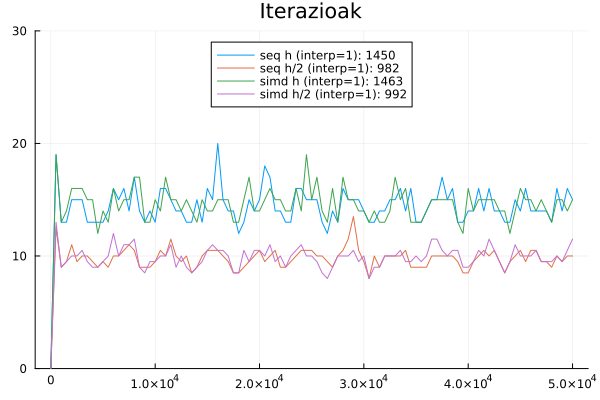

In [20]:
iterfun(iters) = Int64(round(sum(iters)))

p1=plot(title="Iterazioak", ylims=(0,30), legend=:top) #bottom

plot!(sol.t,iters,label="seq h (interp=1): $(iterfun(iters))")
plot!(solh2.t,itersh2,label="seq h/2 (interp=1): $(iterfun(itersh2))")
plot!(sol_s.t,iters_s,label="simd h (interp=1): $(iterfun(iters_s))")
plot!(solh2_s.t,itersh2_s,label="simd h/2 (interp=1): $(iterfun(itersh2_s))")

### Energy erroreak

In [21]:
yrange = (1e-16,1e-4)
year = 365.5

function energy_plot(sol; title="")
    energies = [NbodyEnergy(BigFloat.(u),Gm) for u in sol.u]
    E0 = energies[1]
    epsilon = eps(1e-3)
    errors = Float64.(abs.(energies[2:end]/E0 .- 1)) .+ epsilon
    tt = sol.t[2:end]  #/year
    pl = plot(title=title, ylims=(1e-18,1e-12), xlims=(0, tF),
         yscale=:log10, legend=false) #ylims=yrange, 
    plot!(tt,  errors)
    println(maximum(errors))
    return pl
end

energy_plot (generic function with 1 method)

6.456252908512126e-15
9.39313170815757e-16
6.4273910021730975e-15
2.902973172731387e-16


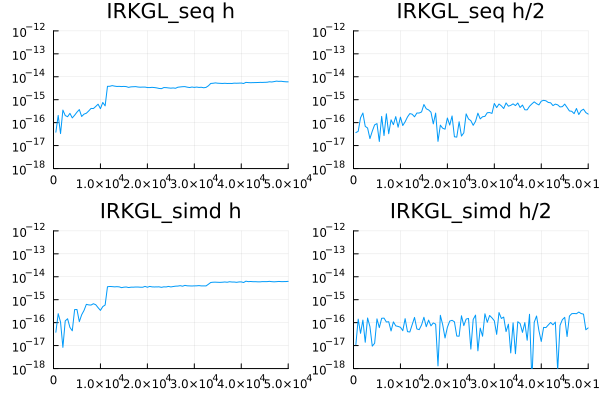

In [22]:
pl = energy_plot(sol, title="IRKGL_seq h")

plh2 = energy_plot(solh2, title="IRKGL_seq h/2")

pl_s = energy_plot(sol_s, title="IRKGL_simd h")

plh2_s = energy_plot(solh2_s, title="IRKGL_simd h/2")


plot(pl, plh2,  pl_s, plh2_s,  layout=(2,2), size=(600,400))